In [1]:
import os
import torch
# Ensure GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")
print(f"Number of available GPUs: {torch.cuda.device_count()}")
 
# Enable device-side assertions
os.environ['TORCH_USE_CUDA_DSA'] = "1"

Selected device: cpu
Number of available GPUs: 0


### Importing Required Libraries

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import BaggingRegressor
from keras.callbacks import EarlyStopping
import keras_tuner as kt

### Functions

In [3]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model performance using RMSE, MAPE, and R2 score.
    """
    predictions = model.predict(X_test)
    rmse_value = np.sqrt(mean_squared_error(y_test, predictions))
    mape_value = mean_absolute_percentage_error(y_test, predictions)
    r2_value = r2_score(y_test, predictions)
    return rmse_value, mape_value, r2_value

def plot_actual_vs_predicted(y_true, y_pred, title):
    """
    Plot the actual vs predicted values.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time (Index)')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

def plot_loss(history, model_name):
    """
    Plot the training and validation loss during model training.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs (Index)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Dataset

In [4]:
# Data Loading and Initial Inspection
data = yf.download('BTC-USD', start='2015-01-01', end='2023-12-31')
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
# Display the first few rows of the data
print("Data Head:")
data.head()

Data Head:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [6]:
# Display the last few rows of the data
print("\nData Tail:")
data.tail()


Data Tail:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-26,43599.847656,43603.175781,41676.488281,42520.402344,42520.402344,30026850982
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055
2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,42156.902344,16013925945


In [7]:
# Summary statistics
print("\nSummary Statistics:")
data.describe()


Summary Statistics:


,Open,High,Low,Close,Adj Close,Volume
count,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3.286000e+03
mean,15021.974057,15373.269205,14643.640114,15033.340909,15033.340909,1.708210e+10
std,16235.870360,16625.794571,15798.240277,16237.727579,16237.727579,1.915699e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,7.860650e+06
25%,1184.262512,1206.202515,1172.047485,1187.825043,1187.825043,3.338000e+08
50%,8639.330566,8818.123535,8382.106445,8659.020508,8659.020508,1.277198e+10
75%,25105.036133,25912.469238,24728.548340,25153.159668,25153.159668,2.742028e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [8]:
# Checking for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [9]:
# Dropping duplicates
data.drop_duplicates(inplace=True)

### Exploratory Data Analysis

#### Univariate Data Visualization

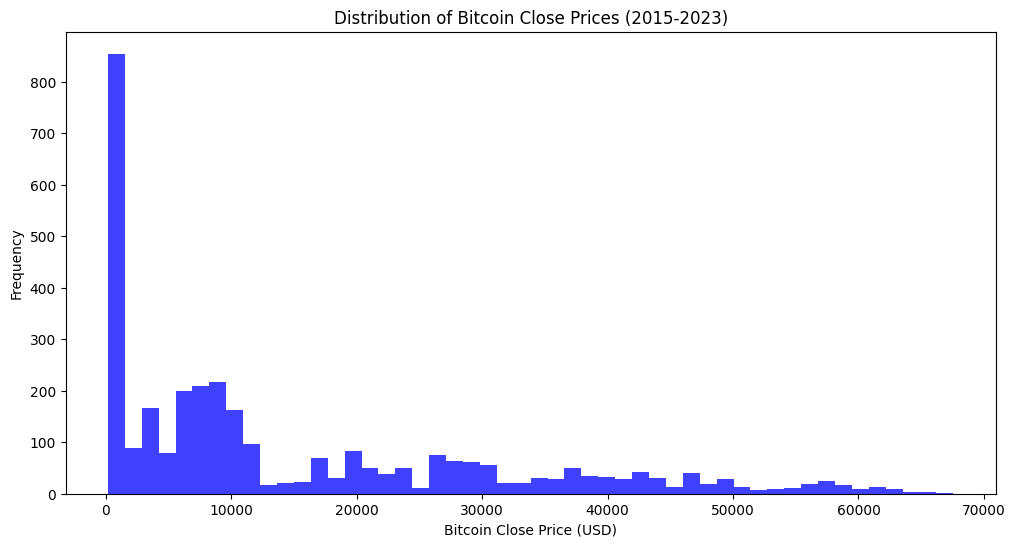

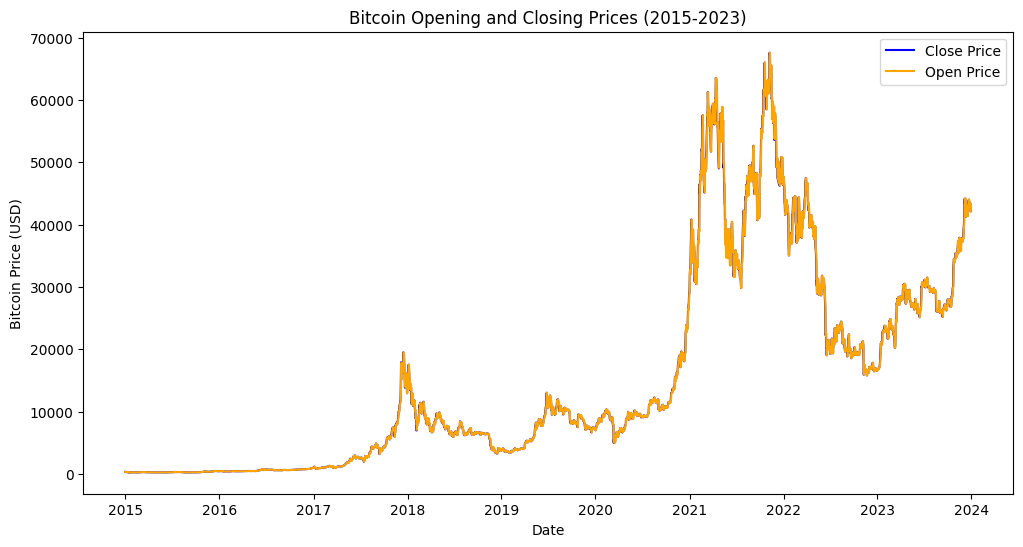

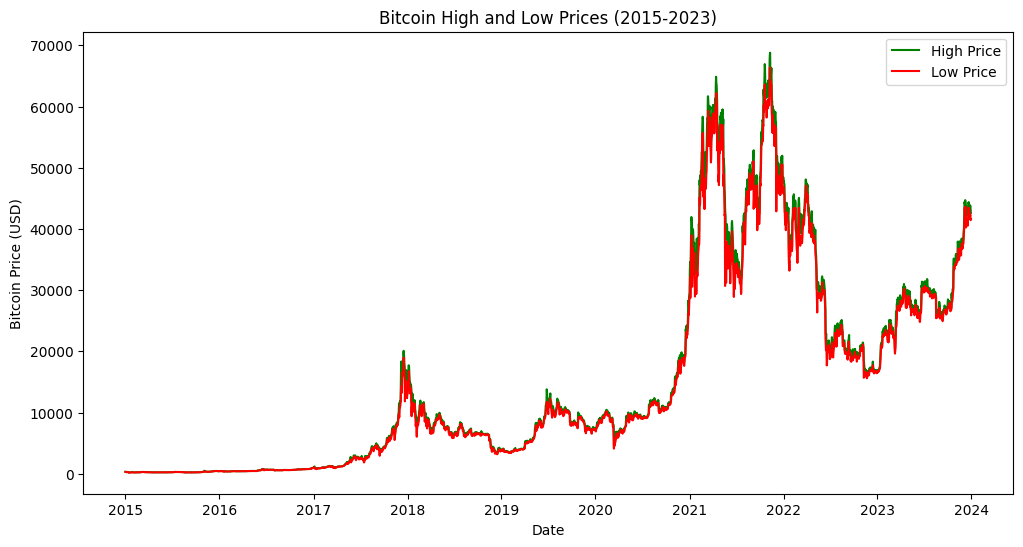

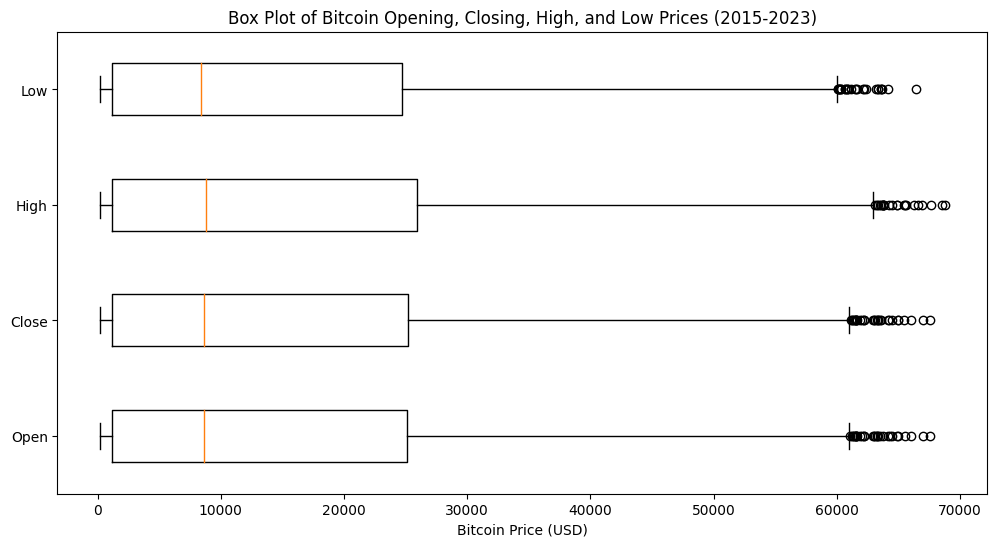

In [10]:
# Function to plot Univariate variable
def plot_univariate(data):
    """
    Plot the distribution and time series of the 'Close' prices, and visualize the open, high, low, and close prices.
    """
    plt.figure(figsize=(12, 6))
    plt.hist(data['Close'], bins=50, alpha=0.75, color='blue')
    plt.title('Distribution of Bitcoin Close Prices (2015-2023)')
    plt.xlabel('Bitcoin Close Price (USD)')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    plt.plot(data.index, data['Open'], label='Open Price', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Bitcoin Price (USD)')
    plt.title('Bitcoin Opening and Closing Prices (2015-2023)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['High'], label='High Price', color='green')
    plt.plot(data.index, data['Low'], label='Low Price', color='red')
    plt.xlabel('Date')
    plt.ylabel('Bitcoin Price (USD)')
    plt.title('Bitcoin High and Low Prices (2015-2023)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.boxplot([data['Open'], data['Close'], data['High'], data['Low']], vert=False, labels=['Open', 'Close', 'High', 'Low'])
    plt.title('Box Plot of Bitcoin Opening, Closing, High, and Low Prices (2015-2023)')
    plt.xlabel('Bitcoin Price (USD)')
    plt.show()
plot_univariate(data)

#### Multivariate Data Visualization

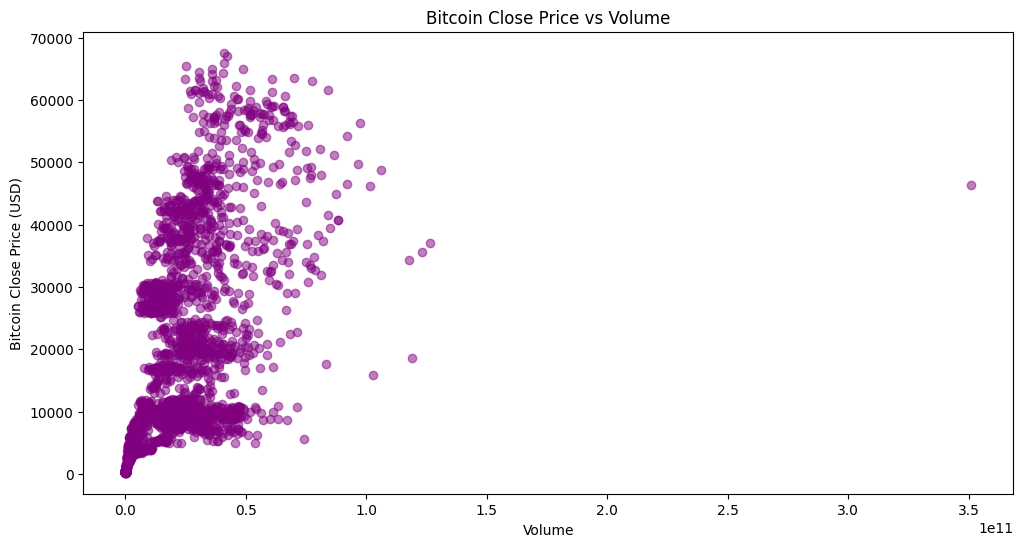

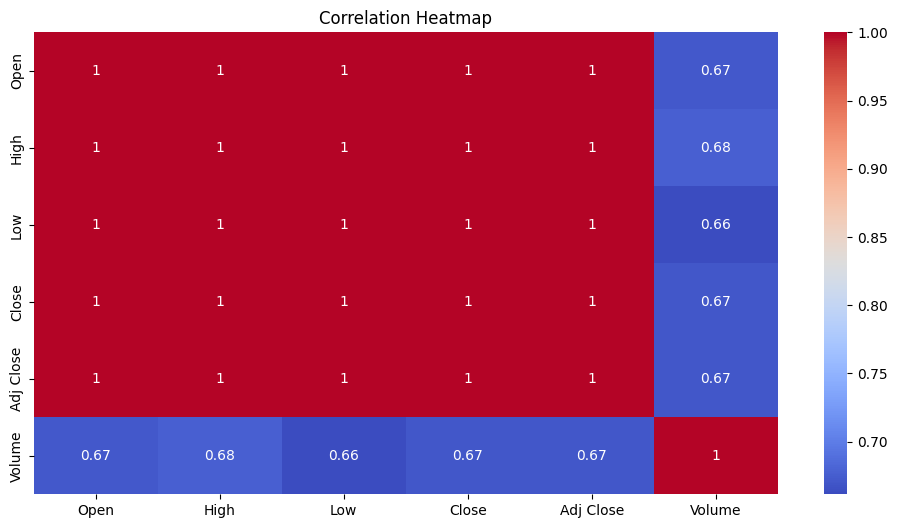

In [11]:
def plot_multivariate(data):
    """
    Plot scatter and correlation heatmap to visualize relationships between variables.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(data['Volume'], data['Close'], alpha=0.5, color='purple')
    plt.title('Bitcoin Close Price vs Volume')
    plt.xlabel('Volume')
    plt.ylabel('Bitcoin Close Price (USD)')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

plot_multivariate(data)

#### Time-based Data Visualization

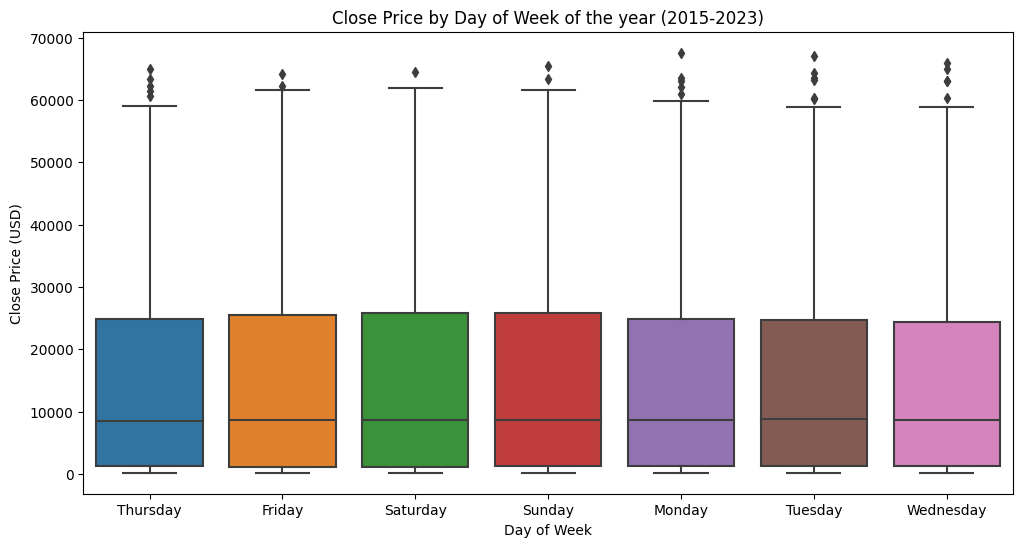

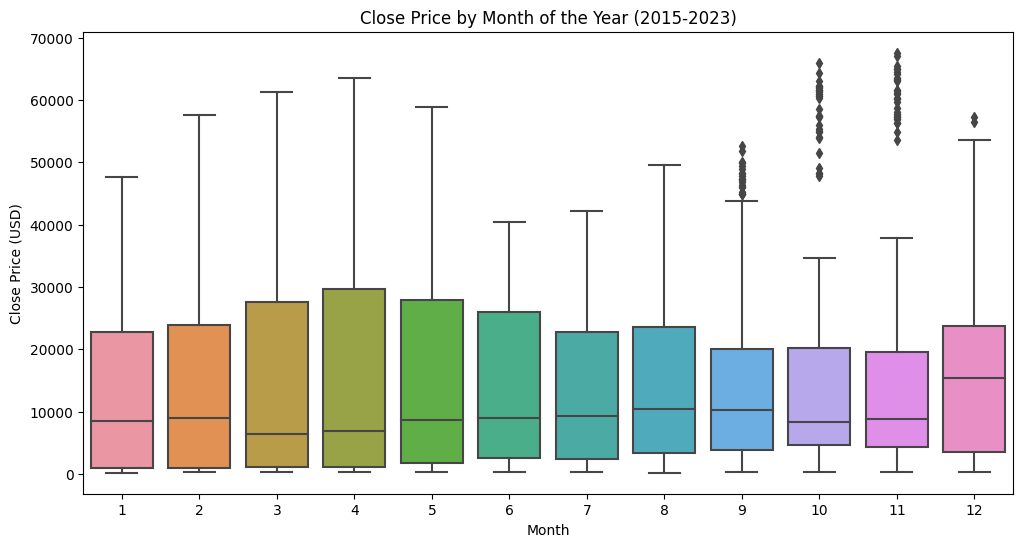

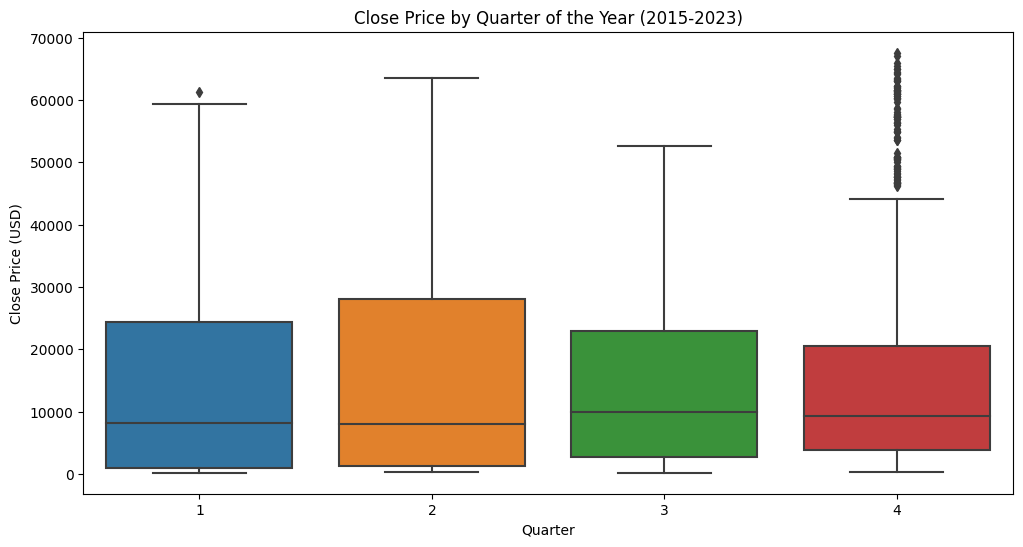

In [12]:
def plot_time_based(data):
    """
    Plot box plots of the close prices based on day, month, and quarter.
    """
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    data['Day'] = data.index.day_name()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Day', y='Close', data=data)
    plt.title('Bitcoin Close Price by Day of Week of the year (2015-2023)')
    plt.xlabel('Day of Week')
    plt.ylabel('Bitcoin Close Price (USD)')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Month', y='Close', data=data)
    plt.title('Close Price by Month of the Year (2015-2023)')
    plt.xlabel('Month')
    plt.ylabel('Close Price (USD)')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Quarter', y='Close', data=data)
    plt.title('Close Price by Quarter of the Year (2015-2023)')
    plt.xlabel('Quarter')
    plt.ylabel('Close Price (USD)')
    plt.show()

plot_time_based(data)

In [13]:
# Feature Scaling and Preparation
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

In [14]:
# Function to create sequences for time series modeling
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Predicting 'Close' price
    return np.array(X), np.array(y)

In [15]:
 # Sequence length 
seq_length = 60
X, y = create_sequences(scaled_features, seq_length)

In [16]:
# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [17]:
# Ensure there are no missing values
assert not np.any(np.isnan(X_train)), "X_train contains NaN values"
assert not np.any(np.isnan(X_test)), "X_test contains NaN values"
assert not np.any(np.isnan(y_train)), "y_train contains NaN values"
assert not np.any(np.isnan(y_test)), "y_test contains NaN values"

# Model Development for Bitcoin Price Prediction

### Deep Learning Models For Bitcoin Price Prediction

#### LSTM

In [22]:
# # Initialize and train the Sequential model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 5)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
65/65 [==============================] - 4s 25ms/step - loss: 7.8047e-04 - val_loss: 0.0069
Epoch 2/50
65/65 [==============================] - 1s 18ms/step - loss: 2.1218e-04 - val_loss: 0.0076
Epoch 3/50
65/65 [==============================] - 1s 18ms/step - loss: 1.6514e-04 - val_loss: 0.0088
Epoch 4/50
65/65 [==============================] - 1s 18ms/step - loss: 1.7453e-04 - val_loss: 0.0119
Epoch 5/50
65/65 [==============================] - 1s 18ms/step - loss: 1.4536e-04 - val_loss: 0.0082
Epoch 6/50
65/65 [==============================] - 1s 21ms/step - loss: 1.3266e-04 - val_loss: 0.0167


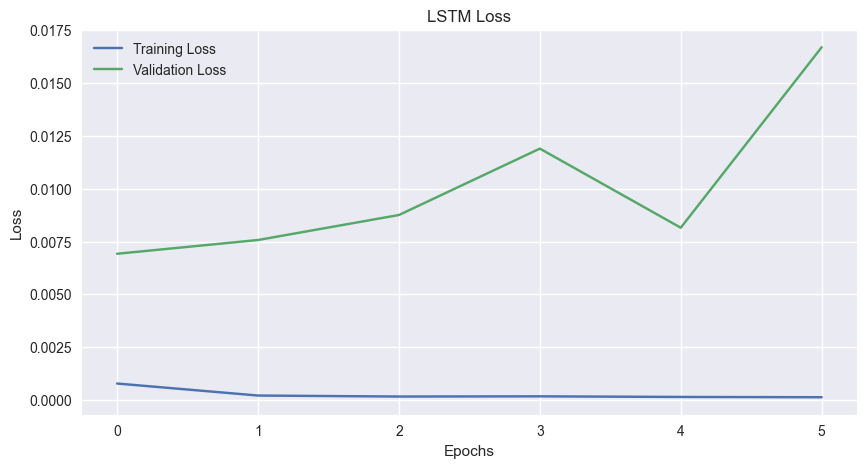

21/21 [==============================] - 0s 5ms/step
LSTM RMSE: 0.03044410089236238, MAPE: 0.053513377448677665, R²: 0.9232444059353903


In [23]:
# Plot training and validation loss
plot_loss(lstm_history, 'LSTM')


# Predict and evaluate LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_rmse, lstm_mape, lstm_r2 = evaluate_model(lstm_model, X_test, y_test)
print(f'LSTM RMSE: {lstm_rmse}, MAPE: {lstm_mape}, R²: {lstm_r2}')

#### GRU

In [25]:
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(seq_length, 5)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=50, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
65/65 [==============================] - 3s 24ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 2/50
65/65 [==============================] - 1s 18ms/step - loss: 1.9199e-04 - val_loss: 0.0020
Epoch 3/50
65/65 [==============================] - 1s 18ms/step - loss: 1.7324e-04 - val_loss: 0.0023
Epoch 4/50
65/65 [==============================] - 1s 17ms/step - loss: 1.3901e-04 - val_loss: 0.0022
Epoch 5/50
65/65 [==============================] - 1s 18ms/step - loss: 1.3457e-04 - val_loss: 0.0022
Epoch 6/50
65/65 [==============================] - 1s 17ms/step - loss: 1.3309e-04 - val_loss: 0.0028
Epoch 7/50
65/65 [==============================] - 1s 17ms/step - loss: 1.1880e-04 - val_loss: 0.0037


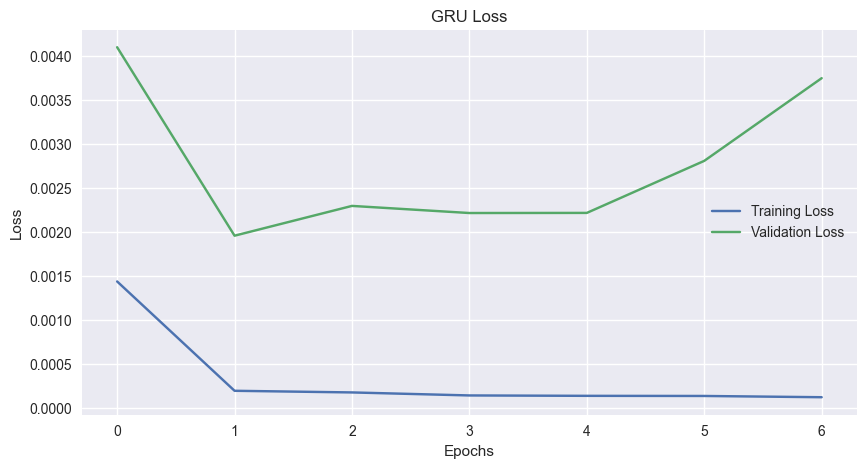

21/21 [==============================] - 0s 4ms/step
GRU RMSE: 0.019993531121776566, MAPE: 0.035186646791700756, R²: 0.9668958273479901


In [26]:
# Plot training and validation loss
plot_loss(gru_history, 'GRU')

# Predict and evaluate GRU model
gru_predictions = gru_model.predict(X_test)
gru_rmse, gru_mape, gru_r2 = evaluate_model(gru_model, X_test, y_test)
print(f'GRU RMSE: {gru_rmse}, MAPE: {gru_mape}, R²: {gru_r2}')

#### Bi-Directional LSTM

In [27]:
bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(seq_length, 5)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Dense(units=1))
bi_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
bi_lstm_history = bi_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
65/65 [==============================] - 6s 37ms/step - loss: 8.6050e-04 - val_loss: 0.0059
Epoch 2/50
65/65 [==============================] - 2s 28ms/step - loss: 1.7519e-04 - val_loss: 0.0042
Epoch 3/50
65/65 [==============================] - 2s 29ms/step - loss: 1.4633e-04 - val_loss: 0.0090
Epoch 4/50
65/65 [==============================] - 2s 30ms/step - loss: 1.2596e-04 - val_loss: 0.0092
Epoch 5/50
65/65 [==============================] - 2s 29ms/step - loss: 1.1296e-04 - val_loss: 0.0109
Epoch 6/50
65/65 [==============================] - 2s 31ms/step - loss: 1.1129e-04 - val_loss: 0.0201
Epoch 7/50
65/65 [==============================] - 2s 31ms/step - loss: 1.0373e-04 - val_loss: 0.0158


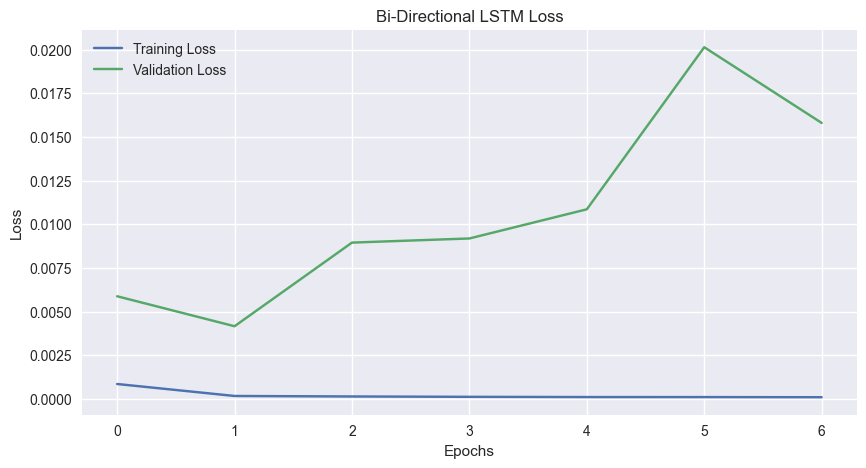

21/21 [==============================] - 0s 7ms/step
Bi-LSTM RMSE: 0.02472508196357114, MAPE: 0.04424482521935711, R²: 0.9493733475031302


In [28]:
# Plot training and validation loss
plot_loss(bi_lstm_history, 'Bi-Directional LSTM')

# Predict and evaluate Bi-LSTM model
bi_lstm_predictions = bi_lstm_model.predict(X_test)
bi_lstm_rmse, bi_lstm_mape, bi_lstm_r2 = evaluate_model(bi_lstm_model, X_test, y_test)
print(f'Bi-LSTM RMSE: {bi_lstm_rmse}, MAPE: {bi_lstm_mape}, R²: {bi_lstm_r2}')

### Ensemble Models Using Deep Learning Models

#### Ensemble Models Using Deep Learning Models

In [29]:
# Weighted Averaging Using Inverse RMSE
inverse_rmse = [1/lstm_rmse, 1/gru_rmse, 1/bi_lstm_rmse]
total_inverse_rmse = sum(inverse_rmse)
weights = [inv_rmse / total_inverse_rmse for inv_rmse in inverse_rmse]

In [30]:
print(f"Calculated Weights: {weights}")

Calculated Weights: [0.2663823905900009, 0.4056198140126265, 0.3279977953973725]


In [31]:
# Generate ensemble predictions using weighted average
ensemble_predictions_weighted = (weights[0] * lstm_predictions +
                                 weights[1] * gru_predictions +
                                 weights[2] * bi_lstm_predictions)

In [32]:
# Evaluate the weighted ensemble model
weighted_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions_weighted))
weighted_mape = mean_absolute_percentage_error(y_test, ensemble_predictions_weighted)
weighted_r2 = r2_score(y_test, ensemble_predictions_weighted)

In [33]:
print(f'Weighted Ensemble RMSE: {weighted_rmse}, MAPE: {weighted_mape}, R²: {weighted_r2}')

Weighted Ensemble RMSE: 0.023581281078836253, MAPE: 0.04187490659853396, R²: 0.9539490576030422


#### Deep Learning Ensemble Model using Stacking

In [34]:
# Split training data into smaller train and validation sets
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Retrain the models on the smaller training set
lstm_model.fit(X_train_small, y_train_small)
gru_model.fit(X_train_small, y_train_small)
bi_lstm_model.fit(X_train_small, y_train_small)

65/65 [==============================] - 2s 25ms/step - loss: 0.0037


In [35]:
# Generate validation predictions
lstm_val_predictions = lstm_model.predict(X_val)
gru_val_predictions = gru_model.predict(X_val)
bi_lstm_val_predictions = bi_lstm_model.predict(X_val)

17/17 [==============================] - 0s 7ms/step


In [36]:
# Stack the predictions for the meta-model
stacked_features = np.column_stack((lstm_val_predictions, gru_val_predictions, bi_lstm_val_predictions))
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_val)

LinearRegression()

In [37]:
# Generate test predictions using the tuned models
lstm_test_predictions = lstm_model.predict(X_test)
gru_test_predictions = gru_model.predict(X_test)
bi_lstm_test_predictions = bi_lstm_model.predict(X_test)

# Stack the test predictions for the meta-model
stacked_test_features = np.column_stack((lstm_test_predictions, gru_test_predictions, bi_lstm_test_predictions))

# Predict using the meta-model
ensemble_predictions_stacking = meta_model.predict(stacked_test_features)

21/21 [==============================] - 0s 6ms/step


In [38]:
# Evaluate the stacked ensemble model
stacked_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions_stacking))
stacked_mape = mean_absolute_percentage_error(y_test, ensemble_predictions_stacking)
stacked_r2 = r2_score(y_test, ensemble_predictions_stacking)
print(f'Stacked Ensemble RMSE: {stacked_rmse}, MAPE: {stacked_mape}, R²: {stacked_r2}')

Stacked Ensemble RMSE: 0.016872423911320274, MAPE: 0.030815073709626887, R²: 0.9764246206925916


### Traditional Machine Learning Models For Bitcoin Price Prediction

In [40]:
# Flattening the input features for traditional ML models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

### Linear Regression Model

In [41]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)
lr_predictions = lr_model.predict(X_test_flat)
lr_rmse, lr_mape, lr_r2 = evaluate_model(lr_model, X_test_flat, y_test)
print(f'Linear Regression RMSE: {lr_rmse}, MAPE: {lr_mape}, R²: {lr_r2}')

Linear Regression RMSE: 0.015716892575303364, MAPE: 0.030334168436915204, R²: 0.9795432281383197


In [42]:
lr_scores = cross_val_score(lr_model, X_train_flat, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Linear Regression Cross-Validated RMSE: {np.sqrt(-np.mean(lr_scores))}')

Linear Regression Cross-Validated RMSE: 0.017260550662252454


### Decision Tree Model

In [43]:
# Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_flat, y_train)
dt_predictions = dt_model.predict(X_test_flat)
dt_rmse, dt_mape, dt_r2 = evaluate_model(dt_model, X_test_flat, y_test)
print(f'Decision Tree RMSE: {dt_rmse}, MAPE: {dt_mape}, R²: {dt_r2}')

Decision Tree RMSE: 0.053624432491163894, MAPE: 0.12871276808857315, R²: 0.7618617540576149


In [44]:
dt_scores = cross_val_score(dt_model, X_train_flat, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Decision Tree Cross-Validated RMSE: {np.sqrt(-np.mean(dt_scores))}')

Decision Tree Cross-Validated RMSE: 0.1965095435484721


### Random Forest Model

In [45]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)
rf_predictions = rf_model.predict(X_test_flat)
rf_rmse, rf_mape, rf_r2 = evaluate_model(rf_model, X_test_flat, y_test)
print(f'Random Forest RMSE: {rf_rmse}, MAPE: {rf_mape}, R²: {rf_r2}')

Random Forest RMSE: 0.05998596328999038, MAPE: 0.15167560051358017, R²: 0.7020090964150816


In [46]:
rf_scores = cross_val_score(rf_model, X_train_flat, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Random Forest Cross-Validated RMSE: {np.sqrt(-np.mean(rf_scores))}')

Random Forest Cross-Validated RMSE: 0.205562749334173


### Gradient Boosting Model

In [47]:
# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_flat, y_train)
gb_predictions = gb_model.predict(X_test_flat)
gb_rmse, gb_mape, gb_r2 = evaluate_model(gb_model, X_test_flat, y_test)
print(f'Gradient Boosting RMSE: {gb_rmse}, MAPE: {gb_mape}, R²: {gb_r2}')

Gradient Boosting RMSE: 0.05702975263191057, MAPE: 0.13039002008613534, R²: 0.7306563706015625


In [48]:
gb_scores = cross_val_score(gb_model, X_train_flat, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Gradient Boosting Cross-Validated RMSE: {np.sqrt(-np.mean(gb_scores))}')

Gradient Boosting Cross-Validated RMSE: 0.20232695779730245


### Support Vector Regression (SVR) Model

In [49]:
# Support Vector Regression
svr_model = SVR()
svr_model.fit(X_train_flat, y_train)
svr_predictions = svr_model.predict(X_test_flat)
svr_rmse, svr_mape, svr_r2 = evaluate_model(svr_model, X_test_flat, y_test)
print(f'SVR RMSE: {svr_rmse}, MAPE: {svr_mape}, R²: {svr_r2}')

SVR RMSE: 0.06691985257778803, MAPE: 0.17186712698856327, R²: 0.6291368494588503


In [50]:
svr_scores = cross_val_score(svr_model, X_train_flat, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'SVR Cross-Validated RMSE: {np.sqrt(-np.mean(svr_scores))}')

SVR Cross-Validated RMSE: 0.24188445004668932


### Ensemble Modeling: Bagging and Boosting with Traditional Machine Learning Models

### Bagging with Linear Regression

In [51]:
# Bagging
bag_lr_model = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, random_state=42)
bag_lr_model.fit(X_train_flat, y_train)
bag_lr_rmse, bag_lr_mape, bag_lr_r2 = evaluate_model(bag_lr_model, X_test_flat, y_test)
print(f'Bagged Linear Regression RMSE: {bag_lr_rmse}, MAPE: {bag_lr_mape}, R²: {bag_lr_r2}')

C:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagged Linear Regression RMSE: 0.014716852103795145, MAPE: 0.027723055080692834, R²: 0.9820636700995993


### Bagging with Decision Tree

In [52]:
bag_dt_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=42)
bag_dt_model.fit(X_train_flat, y_train)
bag_dt_rmse, bag_dt_mape, bag_dt_r2 = evaluate_model(bag_dt_model, X_test_flat, y_test)
print(f'Bagged Decision Tree RMSE: {bag_dt_rmse}, MAPE: {bag_dt_mape}, R²: {bag_dt_r2}')

C:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagged Decision Tree RMSE: 0.05316935014589526, MAPE: 0.13177763014684557, R²: 0.7658865112887852


### Bagging with Support Vector Regression

In [53]:
bag_svr_model = BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=42)
bag_svr_model.fit(X_train_flat, y_train)
bag_svr_rmse, bag_svr_mape, bag_svr_r2 = evaluate_model(bag_svr_model, X_test_flat, y_test)
print(f'Bagged SVR RMSE: {bag_svr_rmse}, MAPE: {bag_svr_mape}, R²: {bag_svr_r2}')

Bagged SVR RMSE: 0.0753661233859654, MAPE: 0.19493353401001925, R²: 0.5296121599754064


C:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


### Boosting with Decision Tree

In [54]:
# Boosting
boost_dt_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50, random_state=42)
boost_dt_model.fit(X_train_flat, y_train)
boost_dt_rmse, boost_dt_mape, boost_dt_r2 = evaluate_model(boost_dt_model, X_test_flat, y_test)
print(f'Boosted Decision Tree RMSE: {boost_dt_rmse}, MAPE: {boost_dt_mape}, R²: {boost_dt_r2}')

C:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Boosted Decision Tree RMSE: 0.06661798527427262, MAPE: 0.17353007798818934, R²: 0.6324751401222771


### Visualization of Models Before Hyperparameter Tuning

In [56]:
# Visualization of Predictions Before Hyperparameter Tuning
ml_models_before = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVR']
ml_predictions_before = [lr_predictions, dt_predictions, rf_predictions, gb_predictions, svr_predictions]

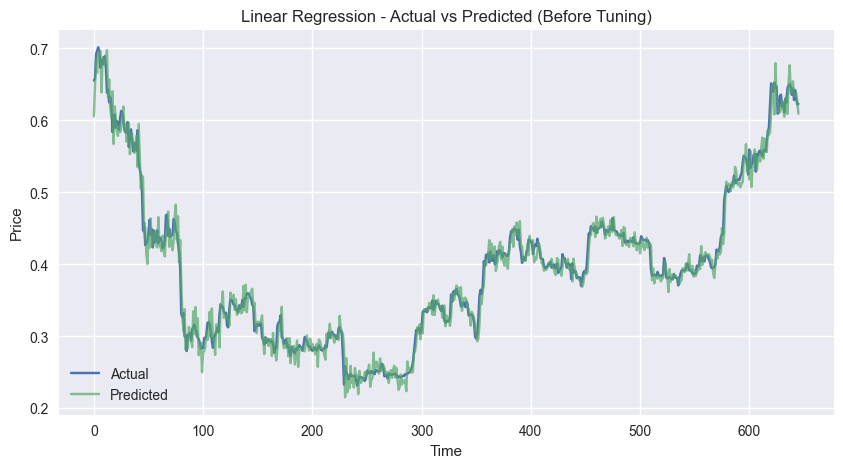

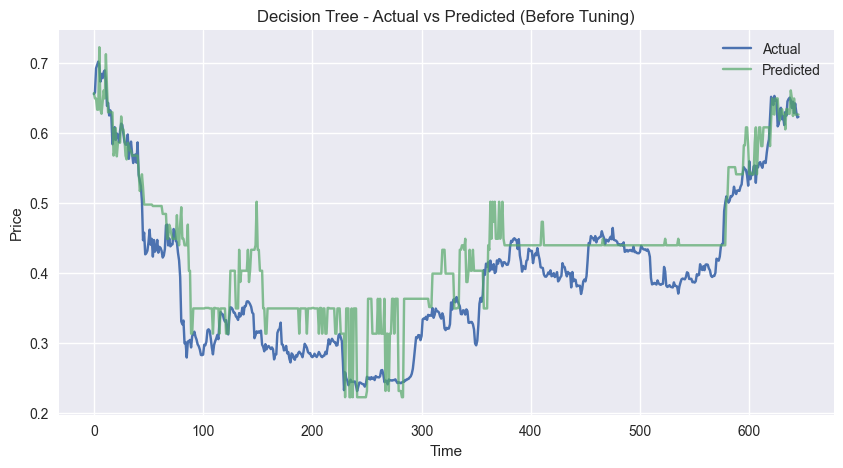

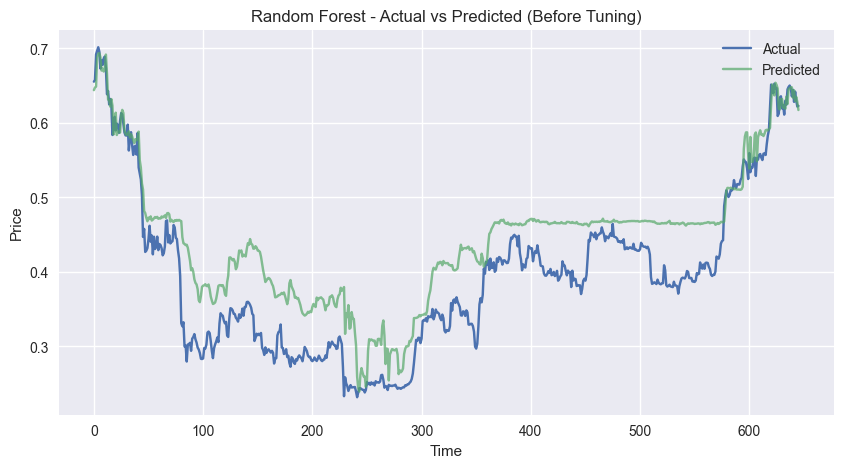

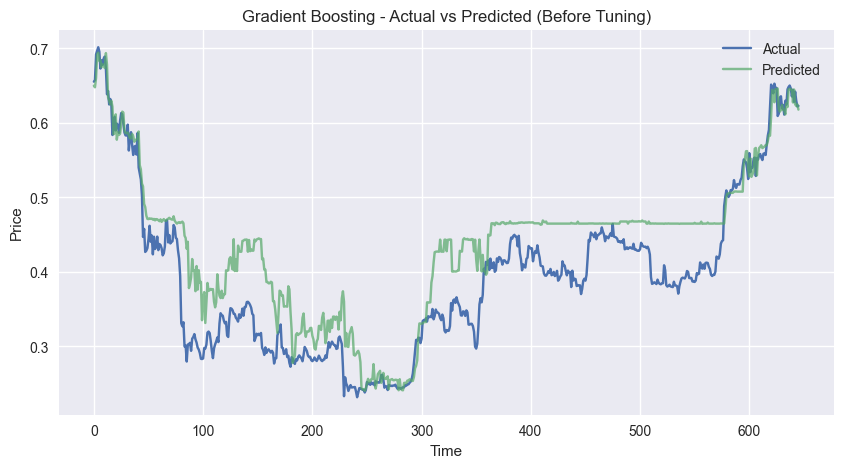

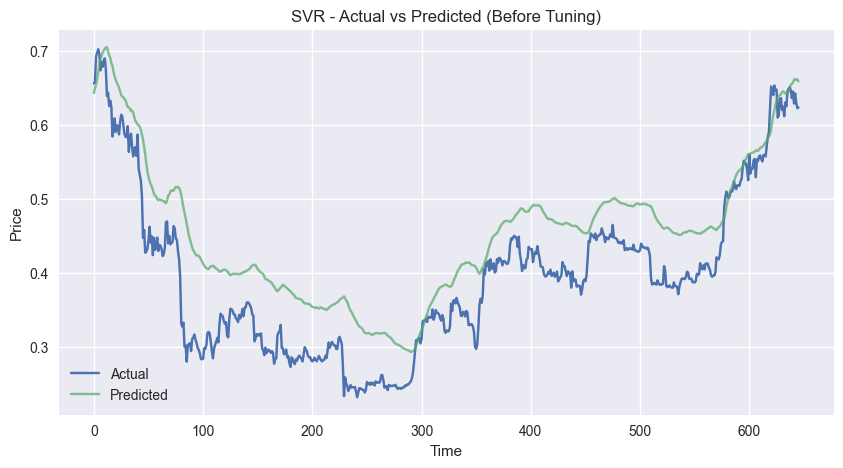

In [57]:
for model_name, predictions in zip(ml_models_before, ml_predictions_before):
    plot_actual_vs_predicted(y_test, predictions, f'{model_name} - Actual vs Predicted (Before Tuning)')

In [58]:
dl_models_before = ['LSTM', 'GRU', 'Bi-LSTM']
dl_predictions_before = [lstm_predictions, gru_predictions, bi_lstm_predictions]

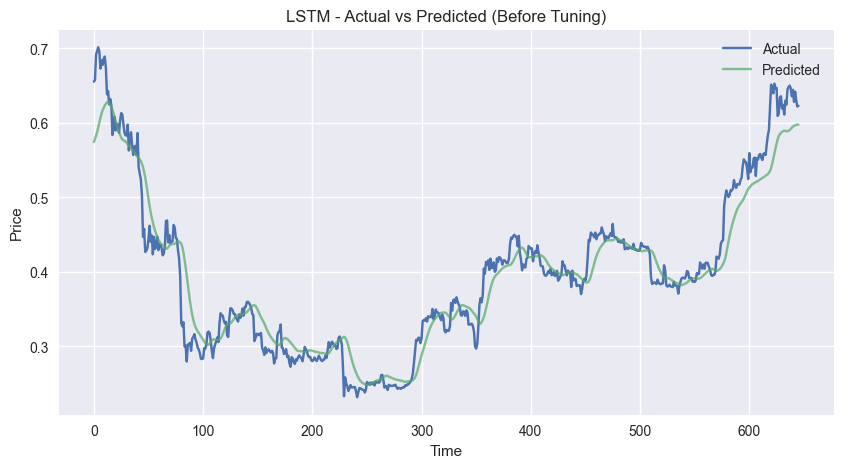

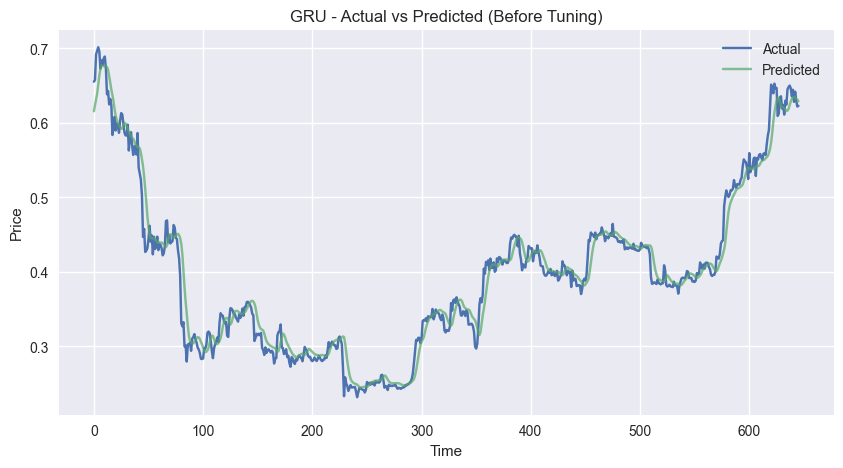

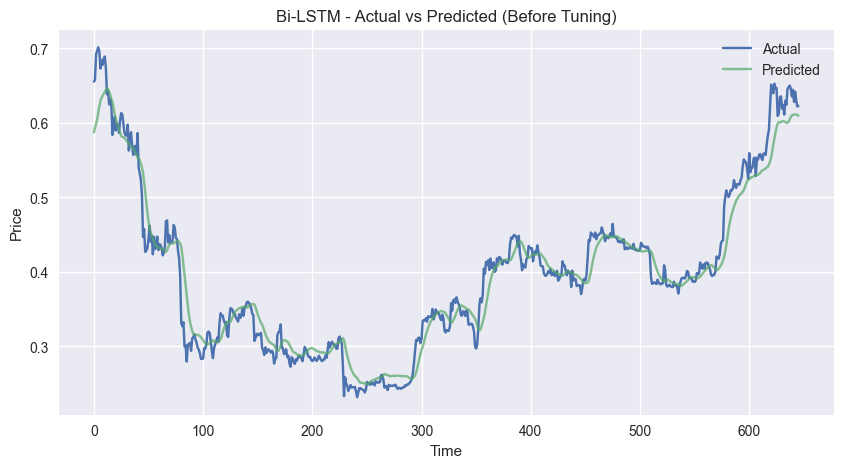

In [59]:
for model_name, predictions in zip(dl_models_before, dl_predictions_before):
    plot_actual_vs_predicted(y_test, predictions, f'{model_name} - Actual vs Predicted (Before Tuning)')

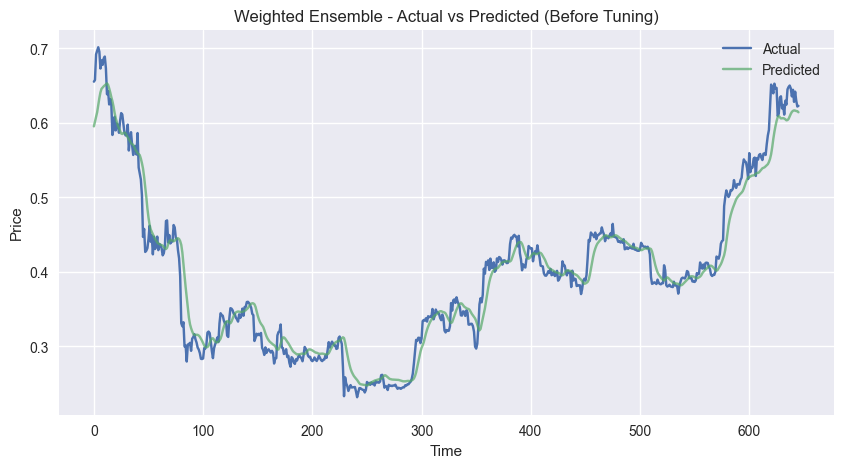

In [60]:
plot_actual_vs_predicted(y_test, ensemble_predictions_weighted, 'Weighted Ensemble - Actual vs Predicted (Before Tuning)')

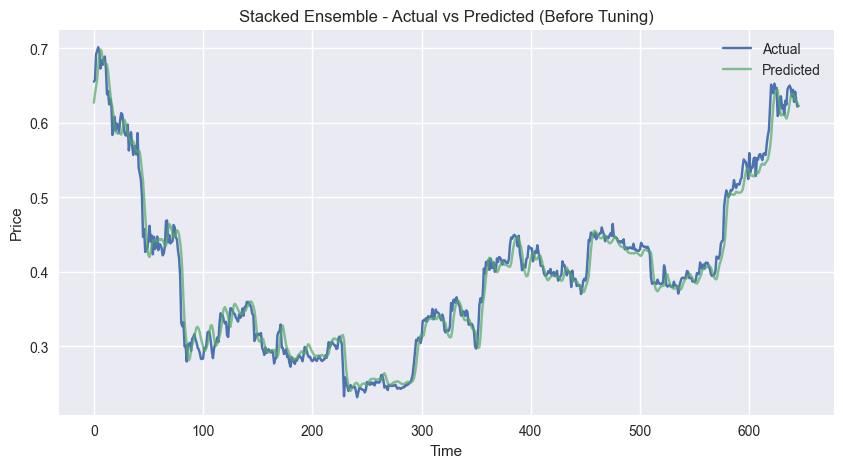

In [61]:
plot_actual_vs_predicted(y_test, ensemble_predictions_stacking, 'Stacked Ensemble - Actual vs Predicted (Before Tuning)')

# Hyperparameter Tuning for Machine Learning Models

### Decision Tree Regressor Hyperparameter Tuning

In [63]:
# Decision Tree Regressor
dt_param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [64]:
dt_grid = GridSearchCV(DecisionTreeRegressor(), dt_param_grid, cv=5, scoring='neg_mean_squared_error')
dt_grid.fit(X_train_flat, y_train)
dt_best_model = dt_grid.best_estimator_
dt_predictions_tuned = dt_best_model.predict(X_test_flat)
dt_rmse_tuned, dt_mape_tuned, dt_r2_tuned = evaluate_model(dt_best_model, X_test_flat, y_test)
print(f'Decision Tree Tuned RMSE: {dt_rmse_tuned}, MAPE: {dt_mape_tuned}, R²: {dt_r2_tuned}')

Decision Tree Tuned RMSE: 0.07691720850535273, MAPE: 0.1966445643252397, R²: 0.5100511293024892


### Random Forest Regressor Hyperparameter Tuning

In [65]:
# Random Forest Regressor
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [66]:
rf_grid = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train_flat, y_train)
rf_best_model = rf_grid.best_estimator_
rf_predictions_tuned = rf_best_model.predict(X_test_flat)
rf_rmse_tuned, rf_mape_tuned, rf_r2_tuned = evaluate_model(rf_best_model, X_test_flat, y_test)
print(f'Random Forest Tuned RMSE: {rf_rmse_tuned}, MAPE: {rf_mape_tuned}, R²: {rf_r2_tuned}')

Random Forest Tuned RMSE: 0.07826298863666084, MAPE: 0.2022596855284168, R²: 0.4927563850685315


###  Gradient Boosting Regressor Hyperparameter Tuning

In [67]:
# Gradient Boosting Regressor
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [68]:
gb_grid = GridSearchCV(GradientBoostingRegressor(), gb_param_grid, cv=5, scoring='neg_mean_squared_error')
gb_grid.fit(X_train_flat, y_train)
gb_best_model = gb_grid.best_estimator_
gb_predictions_tuned = gb_best_model.predict(X_test_flat)
gb_rmse_tuned, gb_mape_tuned, gb_r2_tuned = evaluate_model(gb_best_model, X_test_flat, y_test)
print(f'Gradient Boosting Tuned RMSE: {gb_rmse_tuned}, MAPE: {gb_mape_tuned}, R²: {gb_r2_tuned}')

Gradient Boosting Tuned RMSE: 0.06939151204811238, MAPE: 0.16318805328453923, R²: 0.6012355497609839


### Support Vector Regression Hyperparameter Tuning

In [69]:
# SVR Regressor
svr_param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'gamma': ['scale', 'auto']
}

In [70]:
svr_grid = GridSearchCV(SVR(), svr_param_grid, cv=5, scoring='neg_mean_squared_error')
svr_grid.fit(X_train_flat, y_train)
svr_best_model = svr_grid.best_estimator_
svr_predictions_tuned = svr_best_model.predict(X_test_flat)
svr_rmse_tuned, svr_mape_tuned, svr_r2_tuned = evaluate_model(svr_best_model, X_test_flat, y_test)
print(f'SVR Tuned RMSE: {svr_rmse_tuned}, MAPE: {svr_mape_tuned}, R²: {svr_r2_tuned}')

SVR Tuned RMSE: 0.014328426329364362, MAPE: 0.02742352636177428, R²: 0.9829979721815963


## Visualisations Of Machine Learning Models After Hyper Parameter Tunning

In [71]:
# Visualization of ML Predictions After Tuning
ml_models_after = ['Decision Tree (Tuned)', 'Random Forest (Tuned)', 'Gradient Boosting (Tuned)', 'SVR (Tuned)']
ml_predictions_after = [dt_predictions_tuned, rf_predictions_tuned, gb_predictions_tuned, svr_predictions_tuned]

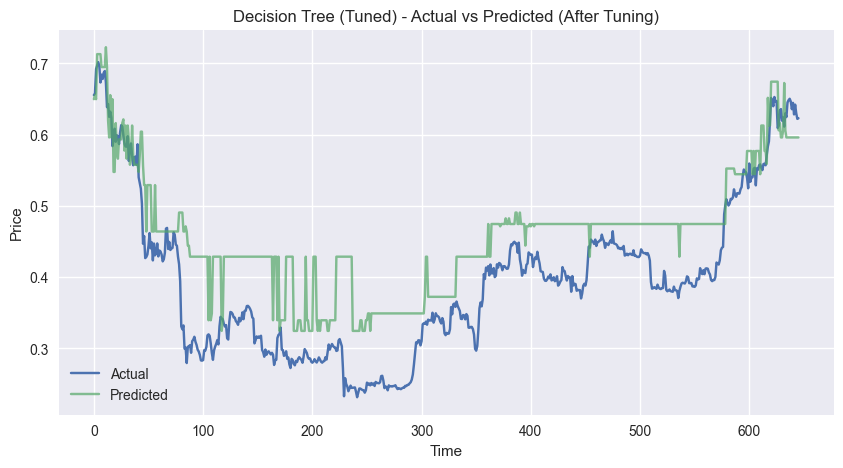

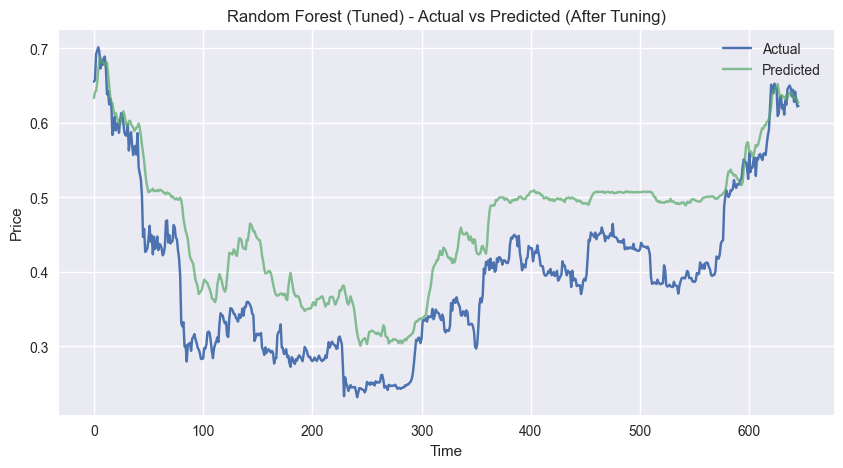

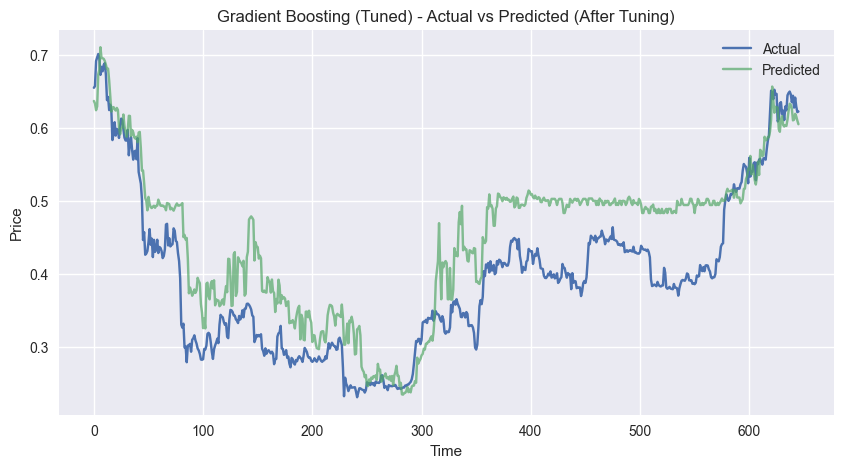

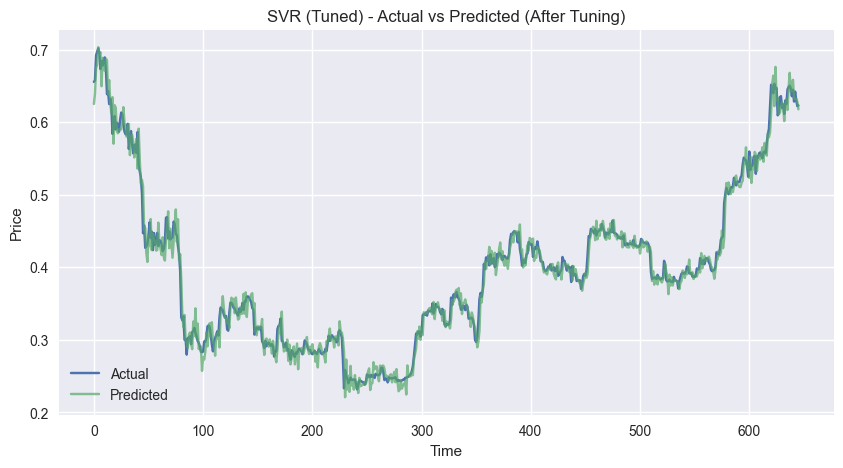

In [72]:
for model_name, predictions in zip(ml_models_after, ml_predictions_after):
    plot_actual_vs_predicted(y_test, predictions, f'{model_name} - Actual vs Predicted (After Tuning)')

# Hyperparameter Tuning for Deep Learning Models

### Hyperparameter Tuning for Deep Learning Models

### LSTM Hyperparameter Tuning

In [41]:

class LSTMHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            return_sequences=True,
            input_shape=(seq_length, 5)
        ))
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            return_sequences=False
        ))
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

In [43]:
lstm_hypermodel = LSTMHyperModel()

In [45]:
lstm_tuner = kt.RandomSearch(
    lstm_hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_tuning'
)

Reloading Tuner from my_dir\lstm_tuning\tuner0.json


In [47]:
lstm_tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

In [49]:
best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]

C:\Users\ugonu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ugonu\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [51]:
# Predict and evaluate the tuned LSTM model
lstm_predictions_tuned = best_lstm_model.predict(X_test)
lstm_rmse_tuned, lstm_mape_tuned, lstm_r2_tuned = evaluate_model(best_lstm_model, X_test, y_test)
print(f'LSTM Tuned RMSE: {lstm_rmse_tuned}, MAPE: {lstm_mape_tuned}, R²: {lstm_r2_tuned}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
LSTM Tuned RMSE: 0.013592659540850408, MAPE: 0.026331963613524335, R²: 0.9846992538289546


###  GRU Hyperparameter Tuning

In [54]:
class GRUHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(GRU(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            return_sequences=True,
            input_shape=(seq_length, 5)
        ))
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(GRU(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            return_sequences=False
        ))
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model


In [56]:
gru_hypermodel = GRUHyperModel()

In [58]:
gru_tuner = kt.RandomSearch(
    gru_hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='gru_tuning'
)

Reloading Tuner from my_dir\gru_tuning\tuner0.json


In [60]:
gru_tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

In [62]:
best_gru_model = gru_tuner.get_best_models(num_models=1)[0]

C:\Users\ugonu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ugonu\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [64]:
# Predict and evaluate the tuned GRU model
gru_predictions_tuned = best_gru_model.predict(X_test)
gru_rmse_tuned, gru_mape_tuned, gru_r2_tuned = evaluate_model(best_gru_model, X_test, y_test)
print(f'GRU Tuned RMSE: {gru_rmse_tuned}, MAPE: {gru_mape_tuned}, R²: {gru_r2_tuned}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
GRU Tuned RMSE: 0.014101546624503011, MAPE: 0.030024266365851912, R²: 0.9835321376722868


### Bi-Directional LSTM Hyperparameter Tuning

In [67]:
class BiLSTMHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Bidirectional(LSTM(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            return_sequences=True,
            input_shape=(seq_length, 5)
        )))
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Bidirectional(LSTM(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            return_sequences=False
        )))
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

In [69]:
bilstm_hypermodel = BiLSTMHyperModel()

In [71]:
bilstm_tuner = kt.RandomSearch(
    bilstm_hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='bilstm_tuning'
)

Reloading Tuner from my_dir\bilstm_tuning\tuner0.json


In [73]:
bilstm_tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

In [75]:
best_bilstm_model = bilstm_tuner.get_best_models(num_models=1)[0]

C:\Users\ugonu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ugonu\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [77]:
bilstm_predictions_tuned = best_bilstm_model.predict(X_test)
bilstm_rmse_tuned, bilstm_mape_tuned, bilstm_r2_tuned = evaluate_model(best_bilstm_model, X_test, y_test)
print(f'Bi-LSTM Tuned RMSE: {bilstm_rmse_tuned}, MAPE: {bilstm_mape_tuned}, R²: {bilstm_r2_tuned}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Bi-LSTM Tuned RMSE: 0.014748424727662173, MAPE: 0.03101728711319033, R²: 0.9819866285634378


### Weighted Ensemble Prediction Using Inverse RMSE After Hyper parameter tunning

In [85]:
# Step 1: Inverse RMSE calculation
inverse_rmse = [
    1/0.012256965191567768,  # LSTM
    1/0.011820079454945604,  # GRU
    1/0.01342814571572971    # Bi-LSTM
]

# Step 2: Total Inverse RMSE
total_inverse_rmse = sum(inverse_rmse)

# Step 3: Calculate Weights
weights = [inv_rmse / total_inverse_rmse for inv_rmse in inverse_rmse]
print(f"Calculated Weights: {weights}")

# Step 4: Apply Weights to Predictions
ensemble_predictions_weighted = (
    weights[0] * lstm_predictions_tuned +
    weights[1] * gru_predictions_tuned +
    weights[2] * bilstm_predictions_tuned
)

# Step 5: Calculate Ensemble RMSE, MAPE, and R²
weighted_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions_weighted))
weighted_mape = mean_absolute_percentage_error(y_test, ensemble_predictions_weighted)
weighted_r2 = r2_score(y_test, ensemble_predictions_weighted)

# Print results
print(f'Weighted Ensemble Tuned RMSE: {weighted_rmse:.4f}, MAPE: {weighted_mape:.4f}, R²: {weighted_r2:.4f}')


Calculated Weights: [0.33901258702150044, 0.3515429396616515, 0.30944447331684805]
Weighted Ensemble Tuned RMSE: 0.0136, MAPE: 0.0283, R²: 0.9846


### Stacked Ensemble Model after Hyperparameter

In [96]:
lstm_model = best_lstm_model  # Best LSTM model after tuning
gru_model = best_gru_model    # Best GRU model after tuning
bi_lstm_model = best_bilstm_model  # Best Bi-LSTM model after tuning

# Re-train the tuned models on a smaller training set (if needed)
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

lstm_model.fit(X_train_small, y_train_small, epochs=50, validation_split=0.2)
gru_model.fit(X_train_small, y_train_small, epochs=50, validation_split=0.2)
bi_lstm_model.fit(X_train_small, y_train_small, epochs=50, validation_split=0.2)

# Generate validation predictions
lstm_val_predictions = lstm_model.predict(X_val)
gru_val_predictions = gru_model.predict(X_val)
bi_lstm_val_predictions = bi_lstm_model.predict(X_val)

# Stack the predictions
stacked_features = np.column_stack((lstm_val_predictions, gru_val_predictions, bi_lstm_val_predictions))

# Train the meta model
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_val)

# Generate test predictions using the tuned models
lstm_test_predictions = lstm_model.predict(X_test)
gru_test_predictions = gru_model.predict(X_test)
bi_lstm_test_predictions = bi_lstm_model.predict(X_test)

# Stack the test predictions
stacked_test_features = np.column_stack((lstm_test_predictions, gru_test_predictions, bi_lstm_test_predictions))

# Predict using the meta model
ensemble_predictions_stacking = meta_model.predict(stacked_test_features)

# Calculate performance metrics
stacked_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions_stacking))
stacked_mape = mean_absolute_percentage_error(y_test, ensemble_predictions_stacking)
stacked_r2 = r2_score(y_test, ensemble_predictions_stacking)

# Print results
print(f'Stacked Ensemble RMSE: {stacked_rmse:.4f}, MAPE: {stacked_mape:.4f}, R²: {stacked_r2:.4f}')


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 7.1907e-04 - val_loss: 2.2936e-04
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 6.4933e-04 - val_loss: 2.7767e-04
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 5.6931e-04 - val_loss: 3.2350e-04
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 6.0967e-04 - val_loss: 2.3819e-04
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 5.3845e-04 - val_loss: 2.2935e-04
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 5.3572e-04 - val_loss: 2.6616e-04
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 5.2582e-04 - val_loss: 2.2985e-04
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 5.0527e-04 - val_loss: 3.7246e-04
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 4.7702e-04 - val_loss: 2.5548e-04
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 5.6399e-04 - val_loss: 2.5600e-04
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 5.0210e-

### Visualization of Deep Learning Predictions After Tuning

In [94]:
dl_models_after = ['LSTM (Tuned)', 'GRU (Tuned)', 'Bi-LSTM (Tuned)']
dl_predictions_after = [lstm_predictions_tuned, gru_predictions_tuned, bilstm_predictions_tuned]

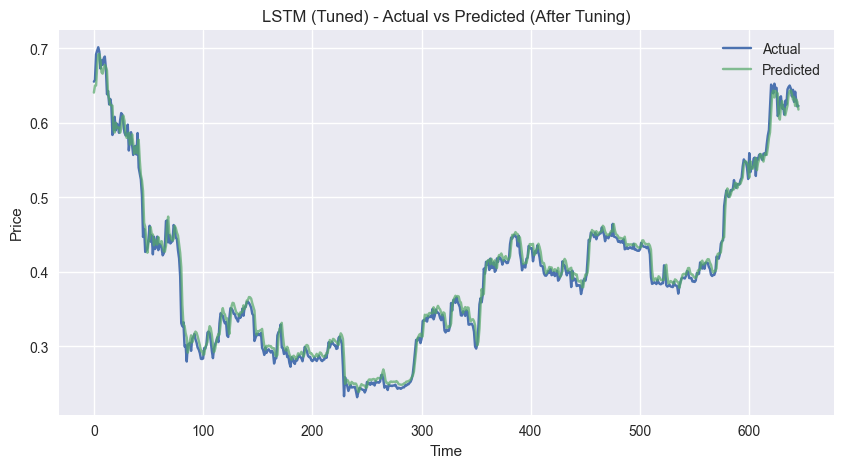

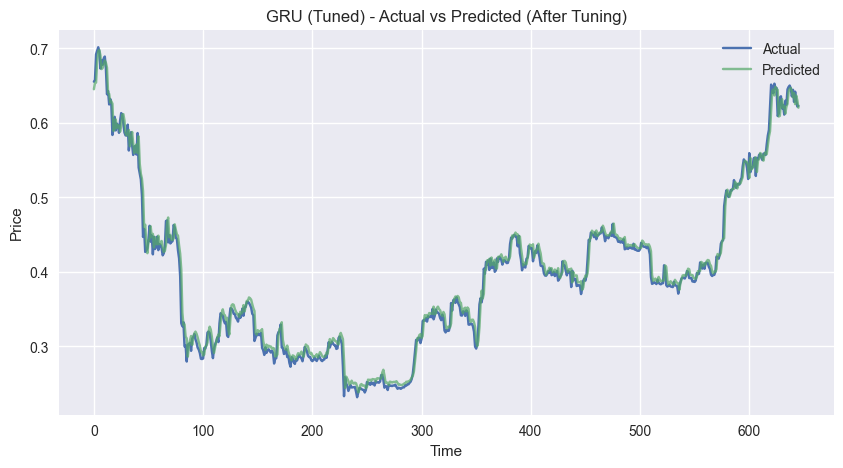

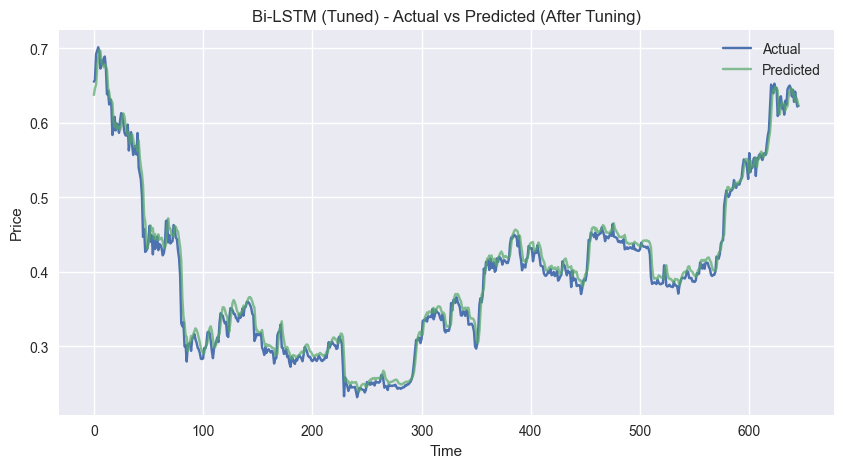

In [94]:
for model_name, predictions in zip(dl_models_after, dl_predictions_after):
    plot_actual_vs_predicted(y_test, predictions, f'{model_name} - Actual vs Predicted (After Tuning)')

### Model Comparison Before and After Hyperparameter Tuning

In [95]:
models_before = ['LSTM', 'GRU', 'Bi-LSTM', 'Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVR']
rmses_before = [lstm_rmse, gru_rmse, bi_lstm_rmse, lr_rmse, dt_rmse, rf_rmse, gb_rmse, svr_rmse]
mapes_before = [lstm_mape, gru_mape, bi_lstm_mape, lr_mape, dt_mape, rf_mape, gb_mape, svr_mape]
r2s_before = [lstm_r2, gru_r2, bi_lstm_r2, lr_r2, dt_r2, rf_r2, gb_r2, svr_r2]

In [96]:
models_after = ['LSTM (Tuned)', 'GRU (Tuned)', 'Bi-LSTM (Tuned)', 'Decision Tree (Tuned)', 'Random Forest (Tuned)', 'Gradient Boosting (Tuned)', 'SVR (Tuned)']
rmses_after = [lstm_rmse_tuned, gru_rmse_tuned, bilstm_rmse_tuned, dt_rmse_tuned, rf_rmse_tuned, gb_rmse_tuned, svr_rmse_tuned]
mapes_after = [lstm_mape_tuned, gru_mape_tuned, bilstm_mape_tuned, dt_mape_tuned, rf_mape_tuned, gb_mape_tuned, svr_mape_tuned]
r2s_after = [lstm_r2_tuned, gru_r2_tuned, bilstm_r2_tuned, dt_r2_tuned, rf_r2_tuned, gb_r2_tuned, svr_r2_tuned]

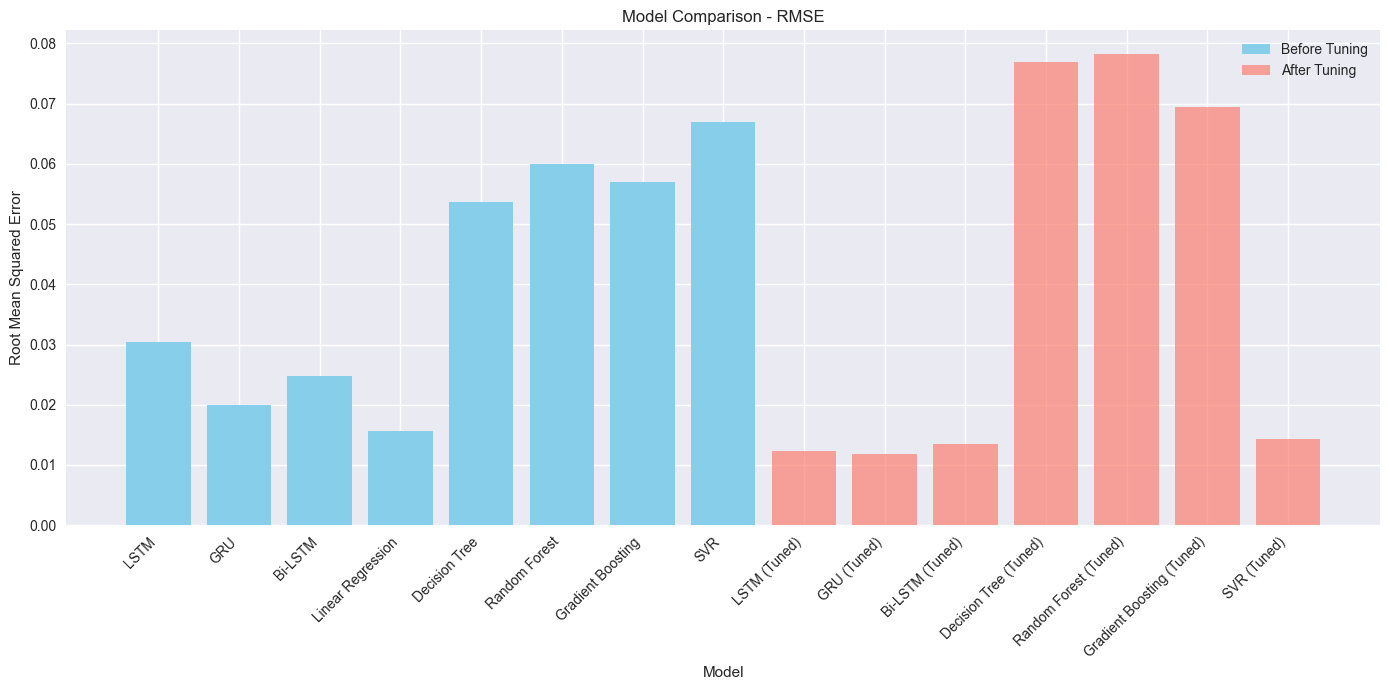

In [97]:
plt.figure(figsize=(14, 7))
plt.bar(models_before, rmses_before, color='skyblue', label='Before Tuning')
plt.bar(models_after, rmses_after, color='salmon', label='After Tuning', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error')
plt.title('Model Comparison - RMSE')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

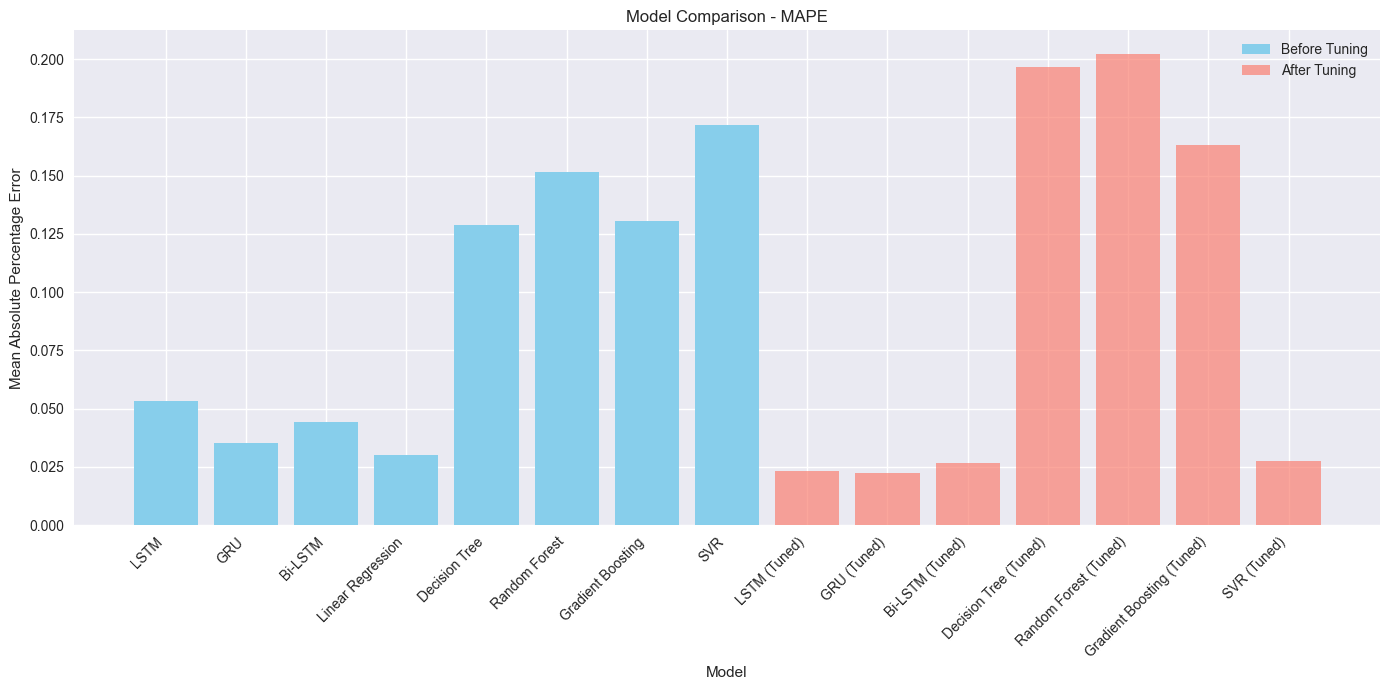

In [98]:
plt.figure(figsize=(14, 7))
plt.bar(models_before, mapes_before, color='skyblue', label='Before Tuning')
plt.bar(models_after, mapes_after, color='salmon', label='After Tuning', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('Model Comparison - MAPE')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

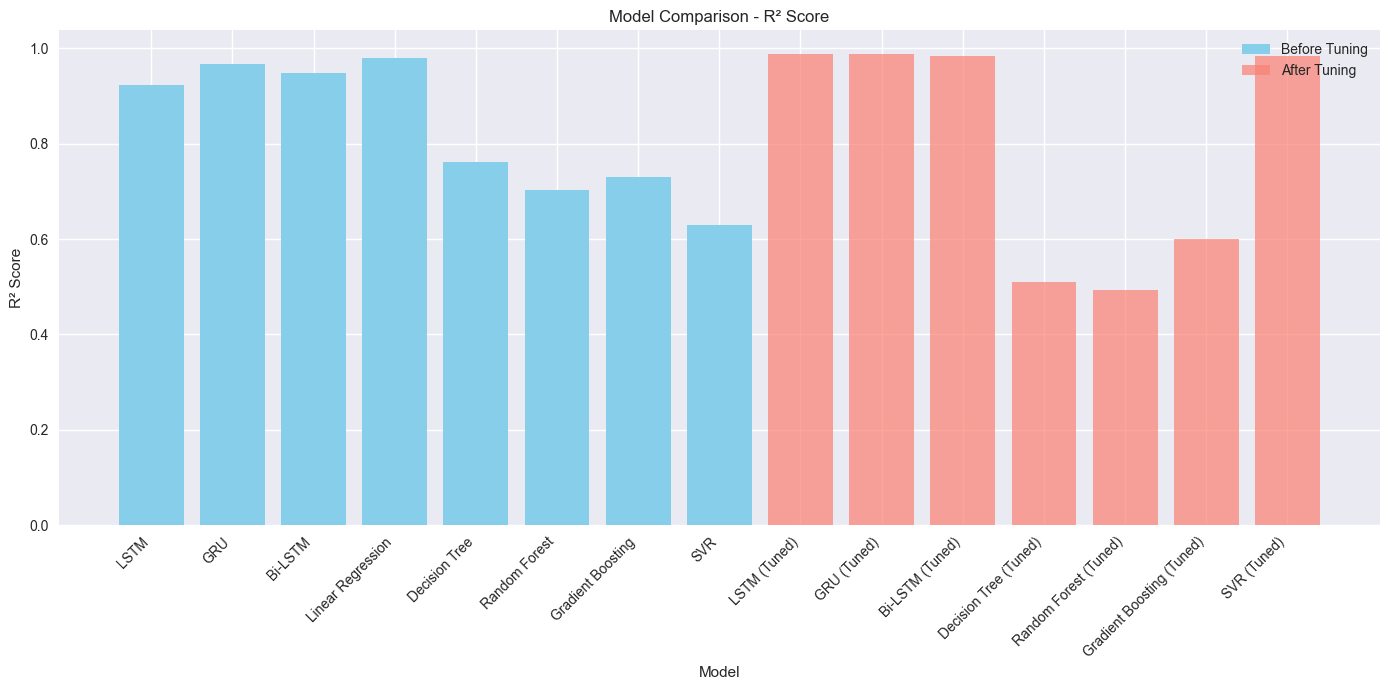

In [99]:
plt.figure(figsize=(14, 7))
plt.bar(models_before, r2s_before, color='skyblue', label='Before Tuning')
plt.bar(models_after, r2s_after, color='salmon', label='After Tuning', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Comparison - R² Score')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Volatility Analysis

In [11]:
# Calculate Daily Returns
data['Daily Return'] = data['Close'].pct_change()

### Visualizing Daily Returns Over Time

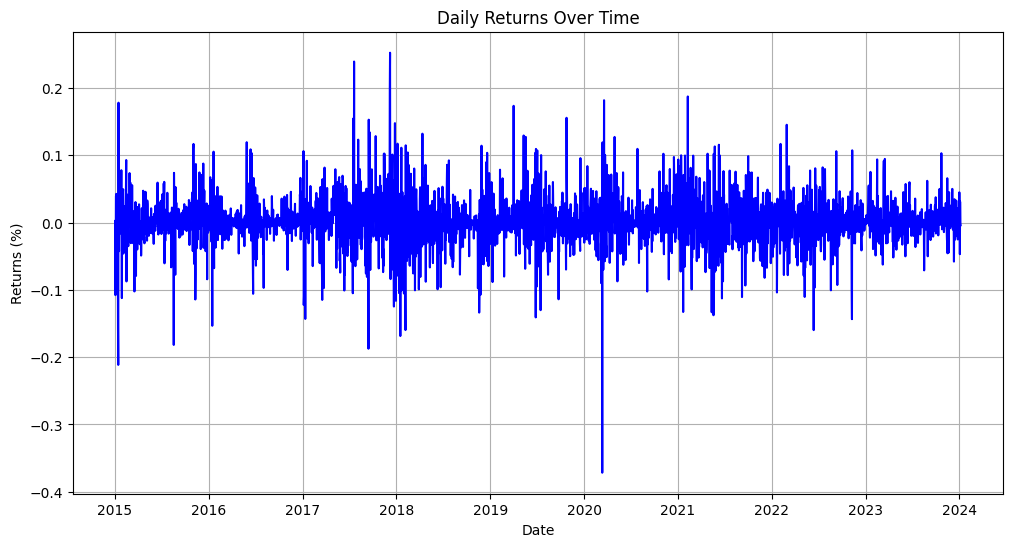

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Daily Return'], label='Daily Returns', color='blue')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns (%)')  # Including units as percentage
plt.grid(True)
plt.show()

### BTC-USD Daily Return and Volatility Analysis

In [14]:
# Calculate rolling volatility (standard deviation of returns)
data['7-Day Volatility'] = data['Daily Return'].rolling(window=7).std() * 100  # Convert to percentage
data['30-Day Volatility'] = data['Daily Return'].rolling(window=30).std() * 100  # Convert to percentage

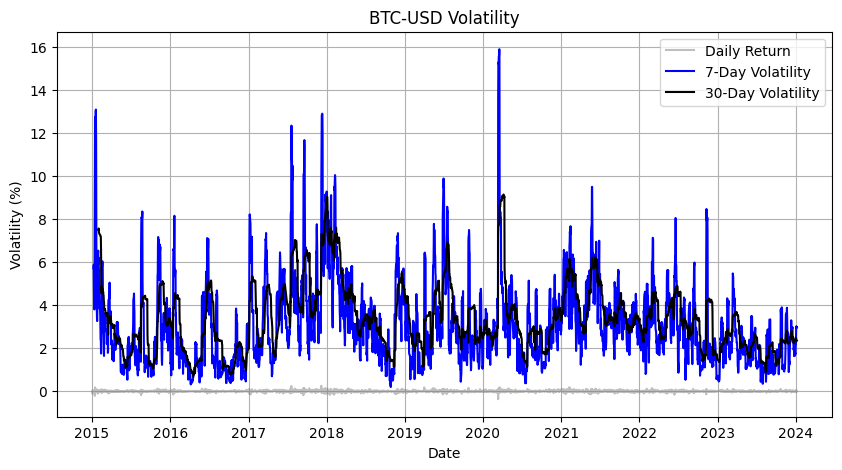

In [17]:
# Plotting volatility
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Daily Return'], label='Daily Return', color='grey', alpha=0.5)
plt.plot(data.index, data['7-Day Volatility'], label='7-Day Volatility', color='blue')
plt.plot(data.index, data['30-Day Volatility'], label='30-Day Volatility', color='black')

plt.title('BTC-USD Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')  # Including units as percentage
plt.legend()
plt.grid(True)
plt.show()

### Bitcoin Price and Volatility Over Time

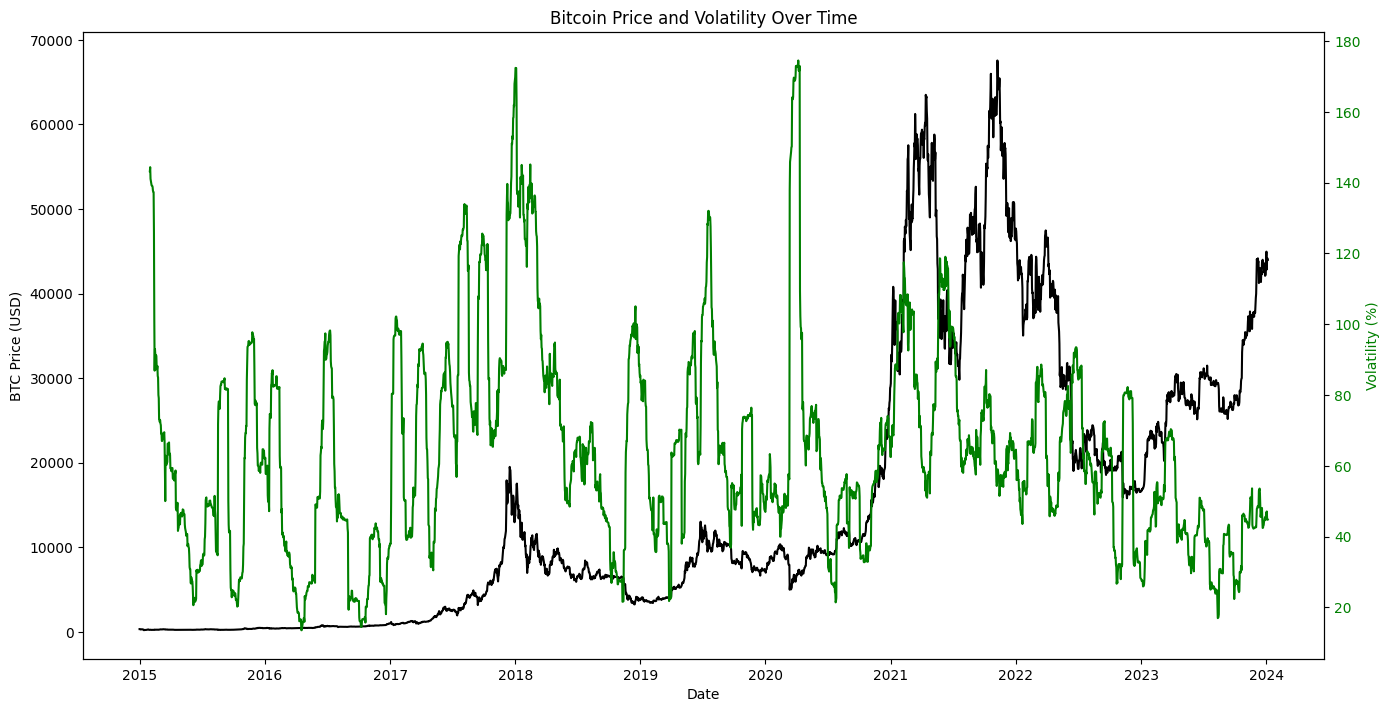

In [18]:
# Calculate daily returns and annualized volatility
data['Annualized Volatility'] = data['Daily Return'].rolling(window=30).std() * np.sqrt(365) * 100  # Annualize and convert to percentage

# Plotting Bitcoin price and volatility
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'black'  # Use a valid color name
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USD)', color=color)  # Price in USD
ax1.plot(data.index, data['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'green'  # Standard color name
ax2.set_ylabel('Volatility (%)', color=color)  # Volatility in percentage
ax2.plot(data.index, data['Annualized Volatility'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Bitcoin Price and Volatility Over Time')
plt.show()

### Time Series Modeling

In [104]:
# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data['Close'][:train_size], data['Close'][train_size:]

#### Augmented Dickey-Fuller (ADF) test to check stationarity

In [105]:
result = adfuller(train)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.2179524409172209
p-value: 0.6658257432883998


In [106]:
if result[1] > 0.05:
    print('Series is non-stationary')
else:
    print('Series is stationary')

Series is non-stationary


##### Differencing to achieve stationarity if needed

In [107]:
train_diff = train.diff().dropna()
result_diff = adfuller(train_diff)

In [108]:
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', result_diff[1])

ADF Statistic after differencing: -8.482454476505067
p-value after differencing: 1.3813830576719354e-13


In [109]:
if result_diff[1] > 0.05:
    print('Series is still non-stationary after differencing')
else:
    print('Series is now stationary after differencing')

Series is now stationary after differencing


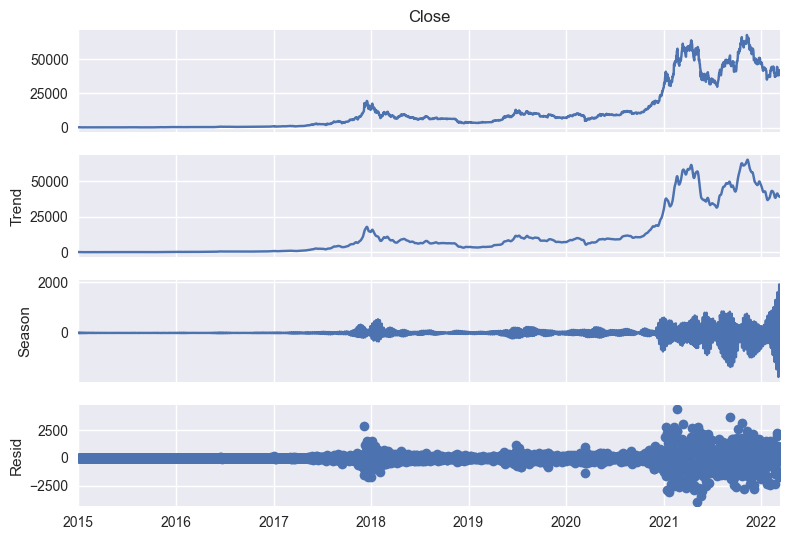

In [110]:
# Seasonal-Trend Decomposition using LOESS (STL)
train = train.asfreq('D')
stl = STL(train, seasonal=13)
result = stl.fit()
result.plot()
plt.show()

#### ARIMA Model

In [111]:
# Define ARIMA model order and fit the model
arima_order = (5, 1, 0)
arima_model = ARIMA(train, order=arima_order)
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(steps=len(test))

In [112]:
# Evaluate ARIMA model
arima_rmse = np.sqrt(mean_squared_error(test, arima_predictions))
arima_mape = mean_absolute_percentage_error(test, arima_predictions)
arima_r2 = r2_score(test, arima_predictions)
print(f'ARIMA RMSE: {arima_rmse}, MAPE: {arima_mape}, R²: {arima_r2}')

ARIMA RMSE: 13952.51010280856, MAPE: 0.5581297258549001, R²: -2.3833921411201873


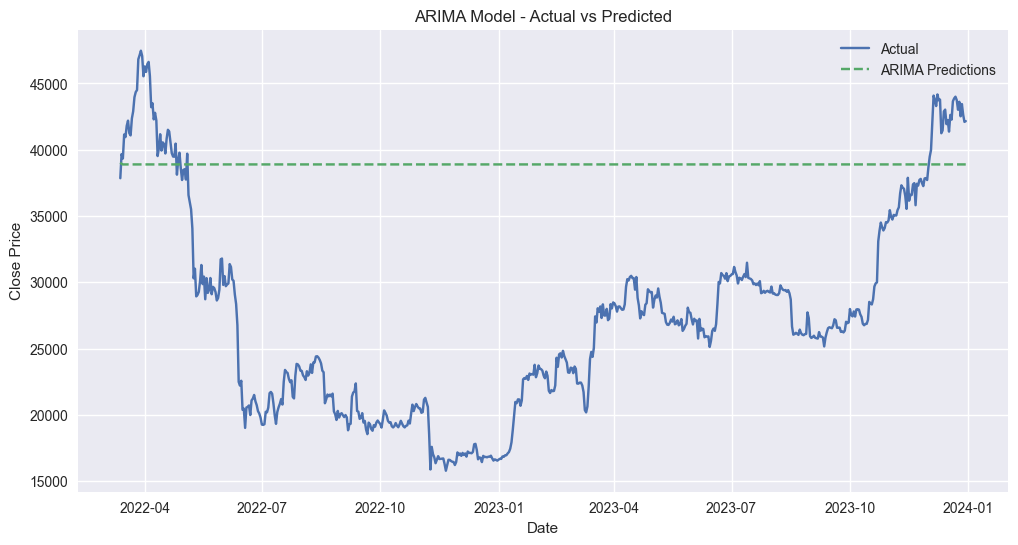

In [113]:
# Plot ARIMA model predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_predictions, label='ARIMA Predictions', linestyle='--')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### SARIMA Model

In [114]:
# Define SARIMA model order and fit the model
sarima_order = (5, 1, 0)
seasonal_order = (1, 1, 1, 12)
sarima_model = SARIMAX(train, order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)
sarima_predictions = sarima_model_fit.forecast(steps=len(test))

In [115]:
# Evaluate SARIMA model
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_predictions))
sarima_mape = mean_absolute_percentage_error(test, sarima_predictions)
sarima_r2 = r2_score(test, sarima_predictions)
print(f'SARIMA RMSE: {sarima_rmse}, MAPE: {sarima_mape}, R²: {sarima_r2}')

SARIMA RMSE: 18462.836325102413, MAPE: 0.7435613902838965, R²: -4.924401512989189


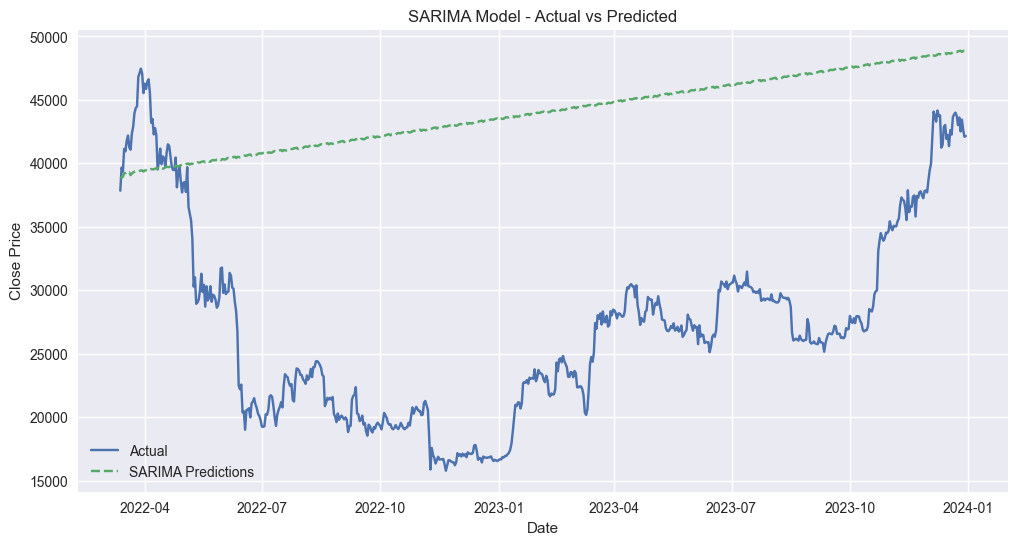

In [116]:
# Plot SARIMA model predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, sarima_predictions, label='SARIMA Predictions', linestyle='--')
plt.title('SARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Displaying Predicted bitcoin Prices

In [104]:
# grenerate predicted price dataframe
predicted_df = pd.DataFrame({'Date': dates, 'Predicted Price': predicted_prices})

# Display the DataFrame as a table
print(predicted_df)

# If you want to format the output with two decimal places
predicted_df['Predicted Price'] = predicted_df['Predicted Price'].apply(lambda x: f"{x:.2f}")

# Display the formatted DataFrame
print("\nPredictions for the Next 7 Days:")
predicted_df.to_string(index=False)


        Date  Predicted Price
0 2023-12-31     42832.010002
1 2024-01-01     43484.210390
2 2024-01-02     43590.365027
3 2024-01-03     44336.180017
4 2024-01-04     45006.860790
5 2024-01-05     45737.583977
6 2024-01-06     46525.876220

Predictions for the Next 7 Days:


'      Date Predicted Price\n2023-12-31        42832.01\n2024-01-01        43484.21\n2024-01-02        43590.37\n2024-01-03        44336.18\n2024-01-04        45006.86\n2024-01-05        45737.58\n2024-01-06        46525.88'

In [3]:
# Data Loading and Initial Inspection
data = yf.download('BTC-USD', start='2015-01-01', end='2024-01-07')
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Display the last few rows of the data
print("\nData Tail:")
data.tail(7)


Data Tail:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-31,42152.097656,42860.937500,41998.253906,42265.187500,42265.187500,16397498810
2024-01-01,42280.234375,44175.437500,42214.976562,44167.332031,44167.332031,18426978443
2024-01-02,44187.140625,45899.707031,44176.949219,44957.968750,44957.968750,39335274536
2024-01-03,44961.601562,45503.242188,40813.535156,42848.175781,42848.175781,46342323118
2024-01-04,42855.816406,44770.023438,42675.175781,44179.921875,44179.921875,30448091210
2024-01-05,44192.980469,44353.285156,42784.718750,44162.691406,44162.691406,32336029347
2024-01-06,44178.953125,44227.632812,43475.156250,43989.195312,43989.195312,16092503468


### Forecasting and Plotting Future Prices with Ensemble Stacking Model

In [122]:
# Generate predictions for the next 7 days using the tuned stacking ensemble model
last_sequence = scaled_features[-seq_length:]  # Get the last available input sequence
predictions = []

# Simulating the ensemble prediction by combining model outputs
for _ in range(7):
    last_sequence = np.expand_dims(last_sequence, axis=0)
    
    # Get predictions from each model
    lstm_pred = lstm_model.predict(last_sequence)[0]
    gru_pred = gru_model.predict(last_sequence)[0]
    bi_lstm_pred = bi_lstm_model.predict(last_sequence)[0]

    # Combine predictions into a stacked feature set
    stacked_features = np.column_stack((lstm_pred, gru_pred, bi_lstm_pred))
    
    # Predict with the meta model (e.g., Linear Regression)
    ensemble_pred = meta_model.predict(stacked_features)[0]  # Ensure your meta model is fitted

    # Append the ensemble prediction
    predictions.append(ensemble_pred)
    
    # Update the last sequence with the new prediction for the next prediction step
    new_sequence = np.append(last_sequence[0, 1:], [[ensemble_pred] * 5], axis=0)
    last_sequence = new_sequence

# Inverse scale the predictions
predicted_prices = scaler.inverse_transform([[0, 0, 0, p, 0] for p in predictions])[:, 3]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


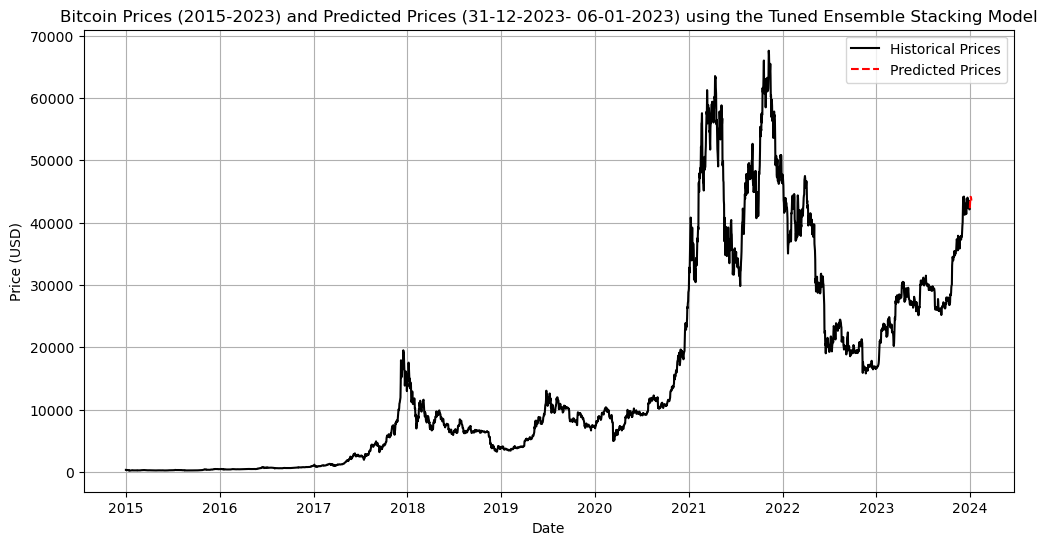

In [124]:
# Dates for plotting predictions
dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=7)
predicted_df = pd.DataFrame({'Date': dates, 'Predicted Price': predicted_prices})
predicted_df.set_index('Date', inplace=True)


# Plotting historical and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Historical Prices', color='black')  # Historical prices
plt.plot(predicted_df.index, predicted_df['Predicted Price'], label='Predicted Prices', color='red', linestyle='--')
plt.title('Bitcoin Prices (2015-2023) and Predicted Prices (31-12-2023- 06-01-2023) using the Tuned Ensemble Stacking Model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()